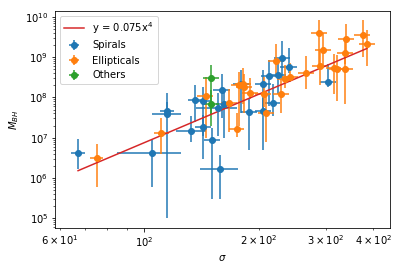

358464


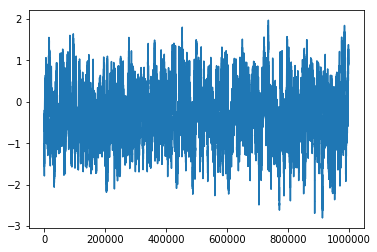

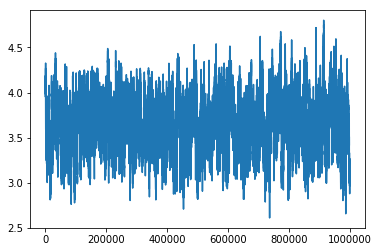

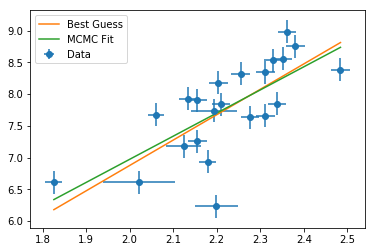

In [143]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

# create Table
tab = Table.read('/media/jeremy/DATA/JeremyDATA/Arizona/Astro513/table.tex')

# split data into galaxy types
sigma_spirals = []
sigma_ellipticals = []
sigma_others = []
sigma_err_spirals = []
sigma_err_ellipticals = []
sigma_err_others = []
M_spirals = []
M_ellipticals = []
M_others = []
M_low_spirals = []
M_low_ellipticals = []
M_low_others = []
M_high_spirals = []
M_high_ellipticals = []
M_high_others = []

# read table
for i in range(len(tab["Galaxy"])):
    # get data values
    sigma = float(tab["sigma"][i][1:-1])
    sigma_err = float(tab["sigma_err"][i][1:-1].replace("$\\tablenotemark{d", ""))
    M_BH = float(tab["M_BH"][i][1:-2].replace("\\times10^{", "e"))
    M_low = float(tab["M_low"][i][1:-2].replace("\\times10^{", "e"))
    M_high = float(tab["M_high"][i][1:-2].replace("\\times10^{", "e"))
    
    #if spiral and not elliptical
    if tab["Type"][i].find("S") != -1 and tab["Type"][i].find("E") == -1:
        sigma_spirals.append(sigma)
        sigma_err_spirals.append(sigma_err)
        M_spirals.append(M_BH)
        M_low_spirals.append(M_low)
        M_high_spirals.append(M_high)
        
    #elif elliptical and not spiral
    elif tab["Type"][i].find("S") == -1 and tab["Type"][i].find("E") != -1:
        sigma_ellipticals.append(sigma)
        sigma_err_ellipticals.append(sigma_err)
        M_ellipticals.append(M_BH)
        M_low_ellipticals.append(M_low)
        M_high_ellipticals.append(M_high)
        
    #else (unsure, irregular, dwarf, etc.)
    else:
        sigma_others.append(sigma)
        sigma_err_others.append(sigma_err)
        M_others.append(M_BH)
        M_low_others.append(M_low)
        M_high_others.append(M_high)
        
# change lists to numpy arrays for calculation ease
M_spirals = np.array(M_spirals)
sigma_spirals = np.array(sigma_spirals)
M_ellipticals = np.array(M_ellipticals)
sigma_ellipticals = np.array(sigma_ellipticals)
M_others = np.array(M_others)
sigma_others = np.array(sigma_others)

# plot data in log space to see power law
plt.errorbar(sigma_spirals, M_spirals, [M_low_spirals, M_high_spirals], sigma_err_spirals, "o", label="Spirals")
plt.errorbar(sigma_ellipticals, M_ellipticals, [M_low_ellipticals, M_high_ellipticals], sigma_err_ellipticals, "o", label="Ellipticals")
plt.errorbar(sigma_others, M_others, [M_low_others, M_high_others], sigma_err_others, "o", label="Others")
xx = np.linspace(np.amin(sigma_spirals), np.amax(sigma_ellipticals), 100)
plt.plot(xx, 0.075*xx**4, label="y = 0.075x$^4$")
plt.xscale("Log")
plt.yscale("Log")
plt.ylabel("$M_{BH}$")
plt.xlabel("$\sigma$")
plt.legend()
plt.show()

# set up the data sets for fitting line in log space, including error propagation
# spirals
y1 = np.log10(M_spirals)
y1_best_err = np.array([max(M_spirals[i] - M_low_spirals[i], M_high_spirals[i] - M_spirals[i]) for i in range(len(M_spirals))])
y1_err = y1_best_err/(M_spirals*np.log(10))
x1 = np.log10(sigma_spirals)
x1_err = sigma_err_spirals/(sigma_spirals*np.log(10))

# remove measurement with too small of error bar - messing up calculations
y1 = np.delete(y1,16)
y1_err = np.delete(y1_err, 16)
y1_err = np.ones(len(y1))*np.mean(y1_err)
x1 = np.delete(x1, 16)
x1_err = np.delete(x1_err, 16)

# ellipticals
y2 = np.log10(M_ellipticals)
y2_best_err = np.array([max(M_ellipticals[i] - M_low_ellipticals[i], M_high_ellipticals[i] - M_ellipticals[i]) for i in range(len(M_ellipticals))])
y2_err = y2_best_err/(M_ellipticals*np.log(10))
x2 = np.log10(sigma_ellipticals)
x2_err = sigma_err_ellipticals/(sigma_ellipticals*np.log(10))

# others
y3 = np.log10(M_others)
y3_best_err = np.array([max(M_others[i] - M_low_others[i], M_high_others[i] - M_others[i]) for i in range(len(M_others))])
y3_err = y3_best_err/(M_others*np.log(10))
x3 = np.log10(sigma_others)
x3_err = sigma_err_others/(sigma_others*np.log(10))

# set up variances here for ease of calculation
y1_err2 = y1_err**2
y2_err2 = y2_err**2
y3_err2 = y3_err**2

# Box-Mueller algorithm
np.random.seed(1)

def box_mueller(z0, sigma, n):
    z1 = np.zeros(n)
    
    for i in range(n):
        x = np.random.rand(2)
        y1 = np.sqrt(-2*np.log(x[0]))*np.cos(2*np.pi*x[1])
        z1[i] = z0 + y1*sigma
        
    return z1

# set up MCMC to find best-fit parameters
a = np.log10(0.075)
b = 4
N = 1000000
ai = np.zeros(N)
bi = np.zeros(N)
ai[0] = np.random.rand()*0.1 + a - 0.05
bi[0] = np.random.rand()*0.1 + b - 0.05
delta1 = box_mueller(0, 0.05, N)
delta2 = box_mueller(0, 0.05, N)
accept = []

# run MCMC on spirals
for i in range(1,N):
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i]]
    P_test = -0.5*np.sum((y1-test[0]-test[1]*x1)**2/y1_err2) - np.log(test[1])
    P_old = -0.5*np.sum((y1-ai[i-1]-bi[i-1]*x1)**2/y1_err2) - np.log(bi[i-1])
    
    if P_test > P_old:
        accept.append(test)
        ai[i] = test[0]
        bi[i] = test[1]
        
    else:
        r = np.random.rand()
        
        if np.log(r) < P_test - P_old:
            accept.append(test)
            ai[i] = test[0]
            bi[i] = test[1]
            
        else:
            ai[i] = ai[i-1]
            bi[i] = bi[i-1]
            
# check acceptance rate for good fit values and parameter chains for convergence
print(len(accept))
plt.plot(np.arange(len(ai)), ai)
plt.show()
plt.plot(np.arange(len(bi)), bi)
plt.show()

plt.errorbar(x1, y1, y1_err, x1_err, "o", label="Data")
xp = np.linspace(np.amin(x1), np.amax(x1), 100)
plt.plot(xp, 4*xp + np.log10(0.075), label="Best Guess")
plt.plot(xp, np.mean(bi)*xp + np.mean(ai), label="MCMC Fit")
plt.legend()
plt.show()